# Tutorial 1: reading and preparing data for an HMP model

In order to fit an HMP model we need neural time-serie data along with the information of the Reaction Time (RT). The data will then be parsed into matrices of values with shape ```epochs X channels X samples X participants``` where samples ranges from the minimum RT to the maximum RT in the data (therefore consider those boundaries carefully). The data of each trial will be cut before stimulus onset and after the recording of a response both because 1) we don't usually consider events outside of this window and 2) because the data can be too large if we just take all the samples in a given window. This tutorial shows you several way to going from recorded EEG data to the expected format. 

For time-series that also come with meaningful spatial locations (e.g. EEG/MEG) we also want to keep and use the location of the electrodes, this will allow us to show the topologoy of the transitions events.For time-series that also come with meaningful spatial locations (e.g. EEG/MEG) we also want to keep and use the location of the electrodes, this will allow us to show the topology of the transitions events.

In this tutorial we will show you how to read data from :

1. Epoched data (recommended)
3. Raw (preprocessed) EEG data in *.bdf* or *.fif* format
4. Data already transformed to PC space (e.g. previous applications of HMP) and example of how to adapt to the expected format

All these methods assume that the data has been preprocessed (e.g. see method section of [this paper](https://psyarxiv.com/nmg6w/) for an example of preprocessing for HMP), if you don't know where to start for preprocessing EEG, the [MNE](https://mne.tools/stable/index.html) is full of tutorials on EEG data.

As other sources of example in preprocessing you can take a look at [an explained example](./preprocessing_example/Template_preprocessing.ipynb) for a full ```mne``` preprocessing pipeline or [here](./sample_data/eeg/0025.ipynb) for an adaptation of matlab data to epoch ready for HMP.


# General data format

## 1. Epoched data (recommended)

Starting from epoched data is the recommended method as the internal functions in hsmm_mvpy to epoch data (see next section) might not be adapted to any kind of experiment. 

An HMP model works on a single trial basis. A trial is defined as the onset of a stimulus and the time at which the response was provided (reation time, RT). Now, to restric the analyzed data to this duration we need to pass the information of the trials RT along the time-series we are using (e.g. EEG/MEG channels). The easiest way of doing this is to rely on the triggers that were co-registered with the data and that signals useful event such as which stimulus was presented and wich answer was given. In MNE this is done by using the metadata (see MNE's [tutorial](https://mne.tools/dev/auto_tutorials/epochs/30_epochs_metadata.htmlhttps://mne.tools/dev/auto_tutorials/epochs/30_epochs_metadata.html)). If your data is already epoched and the co-registered data or conditions that you want to use in the HMP models are already stored in the epoched MNE data then loading data is very easy.

### 1.1 Example with metadata

For this section we will rely on data that can be found in the ```sample_data/``` folder. This data was collected for [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper and fitted using HMP in [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. We downloaded and preprocessed (see preprocessing notebooks in ```sample_data/eeg/```) the data that can be found on the [OSF project](https://osf.io/pd3kf/) of the former paper.

__Imprtant note__ Given that we are using the RT as a cutting point selecting appropriate trimming is very important. For example a typical perceptual decision making is unlikely to be made with RT shorter than 200 ms nor RT longer than 2 seconds. Therefore the next function uses ```lower_limit_RT=0.3``` and ```upper_limit_RT=2``` to apply these criteria.

### 1.1.1 Reading the data

In [2]:
import os 
import hsmm_mvpy as hmp
sfreq = 100 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive for hmp instances

eeg_data_path = os.path.join('sample_data/eeg/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if 'epo.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

epoch_data = hmp.utils.read_mne_data(subj_files, epoched=True, sfreq=sfreq,
                            lower_limit_RT=0.3, upper_limit_RT=2, rt_col='RT', scale=1000,
                            verbose=False, subj_idx=subj_names)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Processing participant sample_data/eeg/processed_0024_2023-06_epo.fif's epoched eeg
171 trials were retained for participant sample_data/eeg/processed_0024_2023-06_epo.fif
Processing participant sample_data/eeg/processed_0022_2023-06_epo.fif's epoched eeg
182 trials were retained for participant sample_data/eeg/processed_0022_2023-06_epo.fif
Processing participant sample_data/eeg/processed_0025_2023-06_epo.fif's epoched eeg
177 trials were retained for participant sample_data/eeg/processed_0025_2023-06_epo.fif
Processing participant sample_data/eeg/processed_0023_2023-06_epo.fif's epoched eeg
191 trials were retained for participant sample_data/eeg/processed_0023_2023-06_epo.fif


```hmp.utils.read_mne_data``` automatically reads the epoched data and converts it to an xarray dataset. Any metadata that has been saved along zith the epoched data is also kept (hence avoid too large metadata and only keep the important metadata).

In [3]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 197, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) <U3 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 190 191 192 193 194 195 196
  * participant  (participant) <U26 'processed_0024_2023-06_epo' ... 'process...
Data variables:
    data         (participant, epochs, electrodes, samples) float64 nan ... nan
    stim         (participant, epochs) float64 nan 1.0 2.0 1.0 ... 2.0 1.0 2.0
    resp         (participant, epochs) object nan 'resp_left' ... 'resp_right'
    RT           (participant, epochs) float64 nan 790.0 ... 386.0 1.277e+03
    cue          (participant, epochs) object nan 'AC' 'SP' ... 'SP' 'SP' 'AC'
    movement     (participant, epochs) object nan 'stim_left' ... 'stim_right'
    trigger      (participant, epochs) object nan ... 'AC/stim_right/resp_right'
Attributes:
    sfreq:    100.0
    offset:   0

And we can now save the data for use in the next tutorials:

In [4]:
epoch_data.to_netcdf('sample_data/sample_data.nc')

### 1.1.2 Working with sensor location

To be able to graphically represent how each transition event translates in the scalp topology we need to pass the info of the channel locations on the head.

Reading /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/tutorials/sample_data/eeg/processed_0024_2023-06_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
183 matching events found
No baseline correction applied
0 projection items activated


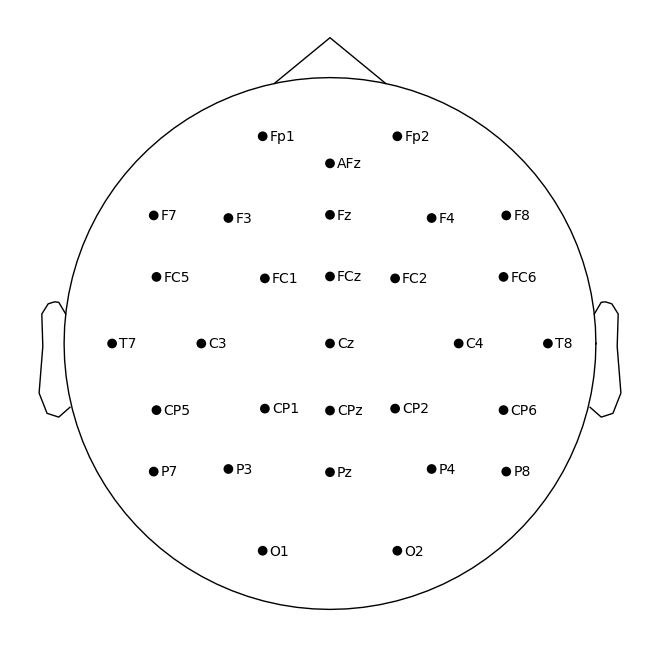

In [5]:
# The following code is just to illustrate channel positions
import mne

epoch = mne.read_epochs(subj_files[0])
epoch.plot_sensors(show_names=True);



When we have access to the mne data format and if the channel positions have been stored during the preprocessing step, the position of the electrode is contained in the ```info``` object from the file we read using ```mne```. Hence we can first read any of the participants data (assuming the electrode position is the same) and 
directly pass that object to the ```plot_topo_timecourse``` . 
We first fit an HMP model (see tutorial 2) to illustrate the use of channel position

In [6]:
epoch_data =  hmp.utils.load_data('sample_data/sample_data.nc')#Just for illustrating how to read the data from the save object
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)# see tutorial 2
init = hmp.models.hmp(hmp_data, epoch_data, cpus=4)# see tutorial 2
estimates = init.fit_single(4)#a 4 stage transition event model see tutorial 2

Estimating 4 events model with 1 starting point(s)
Parameters estimated for 4 events model


We then have the illustration of channel activities for each event: 

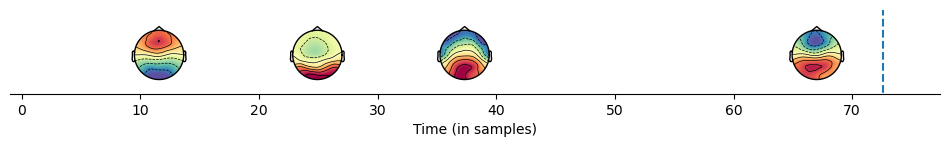

In [7]:
from mne.io import read_info
info = read_info(subj_files[0], verbose=False)
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init)

### 1.2 Example without metadata

If you haven't stored the metadata along with the epoched data you can always provide a list of RTs and condition to parse the data, However you need to be sure that the order of the trials from which you take the info is the same as the EEG data. Here an example with the same data as previously:

In [8]:
import pandas as pd#using pandas to generate the metadata
import xarray as xr#merging the datasets of the individual participants
import numpy as np 
import os 
import hsmm_mvpy as hmp
sfreq = 100 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive for hmp instances

behavioral_data_path = os.path.join('sample_data/behavior/')#Declaring path where the eeg data is
subj_names_EEG = [x.split('.')[0] for x in os.listdir(eeg_data_path) if 'epo.fif' in x]#Extracting subject name based on the file name
subj_eeg_files = [eeg_data_path+x+'.fif' for x in subj_names_EEG]#Create a list of files that can be read from the folder
subj_names = [x.split('_')[1] for x in subj_names_EEG]#Extracting subject name based on the file name

data_group = []#Where to store participants data

for participant in zip(subj_names,subj_eeg_files):#for loop for each participant in the experiment
    print(participant)#keeping track
    #First we read the behavioral data, the name of the colums is at the end of the next line and will depend on your experiment
    behavior = pd.read_csv(os.path.join(behavioral_data_path+'%s-cnv-sat3_ET.csv'%participant[0]), sep=';')[['stim', 'resp', 'RT','cue', 'movement',]]
    #Next we need to store the infos of the RT and experimental conditions for each recorded epochs
    #(optional) we can rename the variable that are numerically coded, this does make your code more transparent for others
    behavior['movement'] = behavior.apply(lambda row: 'stim_left' if row['movement'] == -1 else 
                                      ('stim_right' if row['movement'] == 1 else np.nan), axis=1)
    behavior['resp'] = behavior.apply(lambda row: 'resp_left' if row['resp'] == 1 else 
                                      ('resp_right' if row['resp'] == 2 else np.nan ), axis=1)
    #Merging together the exeperimental conditions info to have the format condition/stimulus/response
    behavior['trigger'] = behavior['cue'] + '/' +  behavior['movement'] + '/' +  behavior['resp']

    #Then we read the associated EEG data 
    data_group.append(hmp.utils.read_mne_data(participant[1], epoched=True, sfreq=sfreq,
                      lower_limit_RT=0.3, upper_limit_RT=2, metadata = behavior, rt_col='RT',\
                      scale=1000, verbose=False, subj_idx=participant[1].split('/')[-1]))#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful    #And use the integrated function in hmp to cut off the epochs to the duration of RTs and declare at which sampling frequency the data is

#Store all this into an xarray file with new 'participant' dimentsion
epoch_data = xr.concat(data_group, pd.Series(subj_names, name="participant"),
                  fill_value={'event':'', 'data':np.nan})

('0024', 'sample_data/eeg/processed_0024_2023-06_epo.fif')
Processing participant sample_data/eeg/processed_0024_2023-06_epo.fif's epoched eeg
True
171 trials were retained for participant sample_data/eeg/processed_0024_2023-06_epo.fif
('0022', 'sample_data/eeg/processed_0022_2023-06_epo.fif')
Processing participant sample_data/eeg/processed_0022_2023-06_epo.fif's epoched eeg
True
182 trials were retained for participant sample_data/eeg/processed_0022_2023-06_epo.fif
('0025', 'sample_data/eeg/processed_0025_2023-06_epo.fif')
Processing participant sample_data/eeg/processed_0025_2023-06_epo.fif's epoched eeg
True
177 trials were retained for participant sample_data/eeg/processed_0025_2023-06_epo.fif
('0023', 'sample_data/eeg/processed_0023_2023-06_epo.fif')
Processing participant sample_data/eeg/processed_0023_2023-06_epo.fif's epoched eeg
True
191 trials were retained for participant sample_data/eeg/processed_0023_2023-06_epo.fif


And this leads to exactly the same data

Finally the position of the electrode can be done as in the previous subsection 1.1.2

Estimating 4 events model with 1 starting point(s)
Parameters estimated for 4 events model


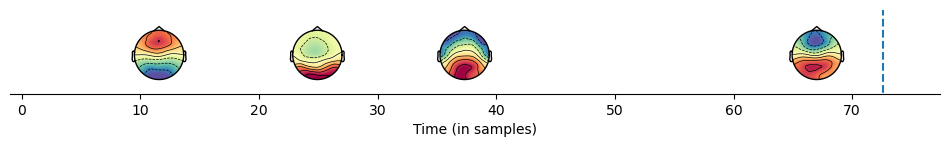

In [9]:
from mne.io import read_info
info = read_info(subj_eeg_files[0], verbose=False)
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)# see tutorial 2
init = hmp.models.hmp(hmp_data, epoch_data, cpus=4)# see tutorial 2
estimates = init.fit_single(4)#a 4 stage transition event model see tutorial 2
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init)

## 1.3 Example with other types of stored epoched data

Lastly perhaps you have your epoched data saved in another format for example a csv file. In this case things are a bit less automatic and you need to carefully look at the data you saved. If we take the same data as previously this would be how you go from both the EEG and behavior saved as csv files

In [10]:
import os 
import numpy as np 
import pandas as pd
import xarray as xr
import hsmm_mvpy as hmp

eeg_data_path = os.path.join('sample_data/eeg/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if 'csv' in x]#Extracting subject name based on the file name

behavioral_data_path = os.path.join('sample_data/behavior/')#Declaring path where the eeg data is

data_group = []#Where to store participants data

for participant in subj_names:#for loop for each participant in the experiment
    #First we read the behavioral data, the name of the colums is at the end of the next line and will depend on your experiment
    behavior = pd.read_csv(os.path.join(behavioral_data_path+'%s-cnv-sat3_ET.csv'%participant), sep=';')[['stim', 'resp', 'RT','cue', 'movement',]]
    #Next we need to store the infos of the RT and experimental conditions for each recorded epochs
    #(optional) we can rename the varaiable that are numerically coded, this does make your code more transparent for others
    behavior['movement'] = behavior.apply(lambda row: 'stim_left' if row['movement'] == -1 else 
                                      ('stim_right' if row['movement'] == 1 else np.nan), axis=1)
    behavior['resp'] = behavior.apply(lambda row: 'resp_left' if row['resp'] == 1 else 
                                      ('resp_right' if row['resp'] == 2 else np.nan ), axis=1)
    #Merging together the exeperimental conditions info to have the format condition/stimulus/response
    behavior['trigger'] = behavior['cue'] + '/' +  behavior['movement'] + '/' +  behavior['resp']
    
    #Next if you want some RTs not to be analyzed (e.g. less than 200 ms because unrealistically fast) you should do this by zeroing out outliers RTs
    behavior['RT'] = behavior.apply(lambda row: 0 if row['RT'] < 300 else (
                0 if row['RT'] > 2000 else row['RT']), axis = 1)
    
    #Then we read the associated EEG data 
    data = pd.read_csv(eeg_data_path+participant+'.csv', index_col=0).reset_index(drop=True)
    #Drop any column that is not time, epoch or electrode name
    data = data.drop(columns='condition')
    #For this specific data we need to rename FP1 and FP2 to align to montage convention
    data = data.rename(columns={'FP1':'Fp1', 'FP2':'Fp2'})
    #And use the integrated function in hmp to cut off the epochs to the duration of RTs and declare at which sampling frequency the data is
    data_group.append(hmp.utils.parsing_epoched_eeg(data=data, rts=behavior['RT'], conditions=behavior['trigger'],  sfreq=100))

#Store all this into an xarray file with new 'participant' dimentsion
epoch_data = xr.concat(data_group, pd.Series(subj_names, name="participant"),
                  fill_value={'event':'', 'data':np.nan})

Totaling 178 valid trials
Totaling 183 valid trials
Totaling 193 valid trials
Totaling 182 valid trials


In [11]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 200, electrodes: 30, samples: 196, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) <U3 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 189 190 191 192 193 194 195
  * participant  (participant) object '0025' '0024' '0023' '0022'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 2.891e+06...
Attributes:
    sfreq:    100
    offset:   0

### 1.3.2 Working with sensor location

If the time-series were to be saved in another format than MNE, then we need to provide an array with the electrode position to the ```plot_topo_timecourse()```. There is no one-fits-it-all solution as this will entirely depend on the nature and ordering of the data. In the case of the same data as all the previous applications, we can rebuild an electrode montage based on MNE's function. When doing so be sure that the ordering of the x,y location of the elctrodes is the same as the ordering of the data.


In [12]:
from mne import channels
montage = dict(channels.make_standard_montage('easycap-M1').get_positions())['ch_pos']#In this case electrodes are positioned according to the 10-20 system
positions = np.array([montage[x][:2] for x in epoch_data['electrodes'].values])#Extract x and y positions of each electrode

We can then pass these positions to the ```plot_topo_timecourse``` and look at the channel activities for each event: 

Estimating 4 events model with 1 starting point(s)
Parameters estimated for 4 events model


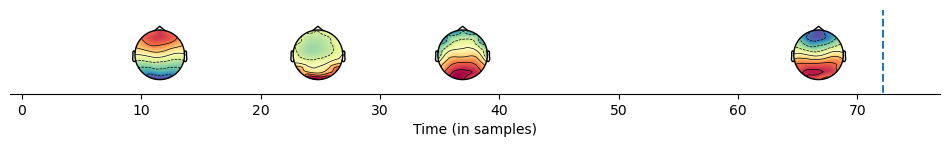

In [13]:
from mne.io import read_info
info = read_info(subj_eeg_files[0], verbose=False)
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)# see tutorial 2
init = hmp.models.hmp(hmp_data, epoch_data, cpus=4)# see tutorial 2
estimates = init.fit_single(4)#a 4 stage transition event model see tutorial 2
hmp.visu.plot_topo_timecourse(epoch_data, estimates, positions, init)

Note that in this case we lose precision compared to the full montage provided with the info file of MNE.

# 2. Reading raw data

subj_filesFor the following I give an example using (yet not public) preprocessed EEG data that has not yet been epoched. This section is useful if you:
- Do not have the behavioral data to use RTs and associated conditions
- Haven't epoched the data or just want to take a quick look at HMP models with raw data laying around

__Nota bene__: the data is assumed to be preprocessed for artifacts and eye-related activity (see an example here: https://github.com/GWeindel/hsmm_mvpy/tree/main/tutorials/preprocessing_example)

First in order for the HMP to run on each trial we have to declare the stimulus triggers as well as the response triggers which defines a trial. 
In the case of this data, the stimulus trigger is a 3 digit code where the first digit codes for the condition (speed or accuracy), the second for the side of the stimulus correct answer and the third one to the stimulus difficulty level. The response trigger codes either left responses or right responses. These triggers will then be used as info for the specific condition of the trial as well as its reaction time (i.e. the time between the stimulus trigger onset and the response trigger onset)

(see Chapter 5 of https://thesiscommons.org/342zp if you want more details on the data and the design)

### 2.1 Reading the data

In [14]:
stimulus_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events

Then we specify wich files we want to analyse, if for example you have all your participant data inside one folder you can do the following :

In [15]:
import os
subj_files = [eeg_data_path+x for x in os.listdir(eeg_data_path) if 'raw.fif' in x]#select files which contain the string 'preprocessed'
subj_names = [x.split('_')[1].split('.')[0] for x in subj_files]#select files which contain the string 'preprocessed'


Next we can directly use the ```subj_file``` list and feed it to the ```hmp.utils.read_mne_data``` but first you have to decide on a number of parameters regarding EEG processing, see the following helper of the function

In [16]:
from hsmm_mvpy import utils
utils.read_mne_data?

Signature:
utils.read_mne_data(
    pfiles,
    event_id=None,
    resp_id=None,
    epoched=False,
    sfreq=None,
    subj_idx=None,
    metadata=None,
    events_provided=None,
    rt_col='rt',
    rts=None,
    verbose=True,
    tmin=-0.2,
    tmax=5,
    offset_after_resp=0,
    high_pass=0.5,
    low_pass=None,
    pick_channels='eeg',
    baseline=(None, 0),
    upper_limit_RT=inf,
    lower_limit_RT=0,
    reject_threshold=None,
    scale=1,
)
Docstring:
Reads EEG/MEG data format (.fif or .bdf) using MNE's integrated function .

Notes: 
- Only EEG or MEG data are selected (other channel types are discarded)
- All times are expressed on the second scale.
- If multiple files in pfiles the data of the group is read and seqentially processed.
- For non epoched data: Reaction Times are only computed if response trigger is in the epoch window (determined by tmin and tmax)

Procedure:
if data not already epoched:
    0.1) the data is filtered with filters specified in low_pass and hig

This is then an example call to the function based on previous _hmp_ applications

In [17]:
import hsmm_mvpy as hmp
sfreq = 100 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive for hmp instances
tmin, tmax = -.25, 2 #window size for the epochs, from 250ms before the stimulus up to 2 seconds after, data will be baseline corrected from tmin to 0
high_pass = 1 #High pass filtering to be applied, useful to avoid slow drifts, parameters of the filters are defined automatically by MNE
lower_limit_RT, upper_limit_RT = .3, 2 #lower and upper limit for the RTs all values outside of this range are discarded

eeg_data = hmp.utils.read_mne_data(subj_files, event_id=stimulus_id, resp_id=resp_id, 
                            subj_idx=subj_names, tmin=tmin, tmax=tmax, sfreq=sfreq,
                            high_pass=high_pass, lower_limit_RT=lower_limit_RT, upper_limit_RT=upper_limit_RT, 
                            verbose=False)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful

Processing participant sample_data/eeg/S7_raw.fif's continuous eeg
Correcting event values as trigger channel has offset [768]
Reading 0 ... 149999  =      0.000 ...  1499.990 secs...
71 trials were retained for participant sample_data/eeg/S7_raw.fif
Processing participant sample_data/eeg/S12_raw.fif's continuous eeg
Reading 0 ... 149999  =      0.000 ...  1499.990 secs...
679 trials were retained for participant sample_data/eeg/S12_raw.fif
Processing participant sample_data/eeg/S10_raw.fif's continuous eeg
Correcting event values as trigger channel has offset [768]
Reading 0 ... 149999  =      0.000 ...  1499.990 secs...
41 trials were retained for participant sample_data/eeg/S10_raw.fif
Processing participant sample_data/eeg/S18_raw.fif's continuous eeg
Correcting event values as trigger channel has offset [768]
Reading 0 ... 149999  =      0.000 ...  1499.990 secs...
45 trials were retained for participant sample_data/eeg/S18_raw.fif


In [18]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 683, electrodes: 64, samples: 200, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 690 691 692 693 694 695 696
  * electrodes   (electrodes) <U3 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * participant  (participant) <U12 'data/eeg/S7' ... 'data/eeg/S18'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 6.781e-06...
    event_name   (participant, epochs) object 'speed/left/3' ... nan
    rt           (participant, epochs) float64 0.44 0.47 nan ... nan nan nan
Attributes:
    sfreq:    100.0
    offset:   0

### 2.2 Working with sensor location

In this case as in the first example with epoched data, we can simply call the info object of one of the file to use the positions of the electrodes.

Estimating 4 events model with 1 starting point(s)
Parameters estimated for 4 events model


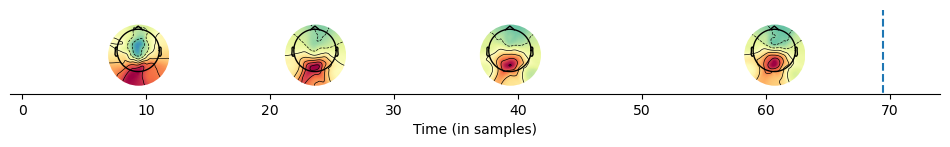

In [19]:
hmp_data = hmp.utils.transform_data(eeg_data, n_comp=4)# see tutorial 2
init = hmp.models.hmp(hmp_data, eeg_data, cpus=4)# see tutorial 2
estimates = init.fit_single(4)#a 2 stage transition event model see tutorial 2

from mne.io import read_info
info = read_info(subj_files[0], verbose=False)#In this case we recorded the actual position of the electrodes
hmp.visu.plot_topo_timecourse(eeg_data, estimates, info, init)

# 3. Data already transformed to PC space (e.g. previous applications of HMP MVPA)


This part is addressed mainly for researchers wanting to replicate previous findings with matlab with data that has already been turned into principal component space and contains therefore __very specific code__ that most users will probably not need. Users who have other data format as the one listed in the previous section can probably also use this code to adapt to their specific format.

For this example we will use the data from the study by Anderson, Zhang, Borst, & Walsh ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) that you can download here: http://www.ai.rug.nl/~jpborst/modelbasedneuro/analysis_data_model.zip

### 3.1 Reading the data

__IMPORTANT__: if you want to run this part of the notebook you need to download the [data](http://www.ai.rug.nl/~jpborst/modelbasedneuro/analysis_data_model.zip) and put the files ```analysis_data_model/data/varForevents135_100.mat```  and ```analysis_data_model/analysis/HSMM_code/chanlocs.mat``` in the same folder as the notebook.

First we read the .mat data file using ```scipy```

In [20]:
import scipy.io
import numpy as np

mat = scipy.io.loadmat('varForBumps135_100.mat')#Where the .mat file with all the data and necessary infos is
data = np.array(mat['normedscore10'])[:,:5]# The data in PC space, limiting to 5 PC
starts = np.array(mat['x'][:1000,0]) -1#correcting to be 0 indexed, limiting to 1000 first points
ends = np.array(mat['y'][:1000,0])-1#correcting to be 0 indexed, limiting to 1000 first points
subjects = np.array(mat['subjects'])[:1000]-1 #correcting to be 0 indexed, limiting to 1000 first points

Here we will adapt the structure of the matlab data to the expected data format

In [21]:
### Recovering RTs, trials and participants
durations = ends - starts + 1
limits = np.cumsum(durations)
limits = np.concatenate([[0],limits])
participant, trials = np.unique(subjects, return_counts=True)


# creating data watrix with participant x trial x max duration x electrodes/comp
unstacked_data = np.tile(np.nan, (len(participant), np.max(trials), np.shape(data)[1], np.max(durations)))
conditions = np.tile(np.nan, (len(participant), np.max(trials)))
for trial in np.arange(len(durations)):
    if trial > 0 and subjects[trial] == subjects[trial-1]:
        within_trial += 1
    else:
        within_trial = 0
    unstacked_data[subjects[trial], within_trial, :,:durations[trial],] = data[limits[trial]:limits[trial+1]].T
    conditions[subjects[trial], within_trial] = mat['conds'][trial]

unstacked_data = hmp.utils.hmp_data_format(unstacked_data, conditions, sfreq=100, participants=participant)#converting to xarray
unstacked_data = unstacked_data.rename({'electrodes':'component'})#Data is already on PC space so no need to use the transform function
unstacked_data.to_netcdf('unstacked_data.nc')#saving the converted data

In [22]:
unstacked_data

<xarray.Dataset>
Dimensions:      (participant: 2, epochs: 770, component: 5, samples: 300)
Coordinates:
  * participant  (participant) uint8 0 1
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 763 764 765 766 767 768 769
  * component    (component) int64 0 1 2 3 4
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
Data variables:
    data         (participant, epochs, component, samples) float64 2.294 ... nan
Attributes:
    sfreq:    100
    offset:   0

### 3.2 Working with sensor location

Now the data is in the expected format for HMP however we still need to recover the electrodes position

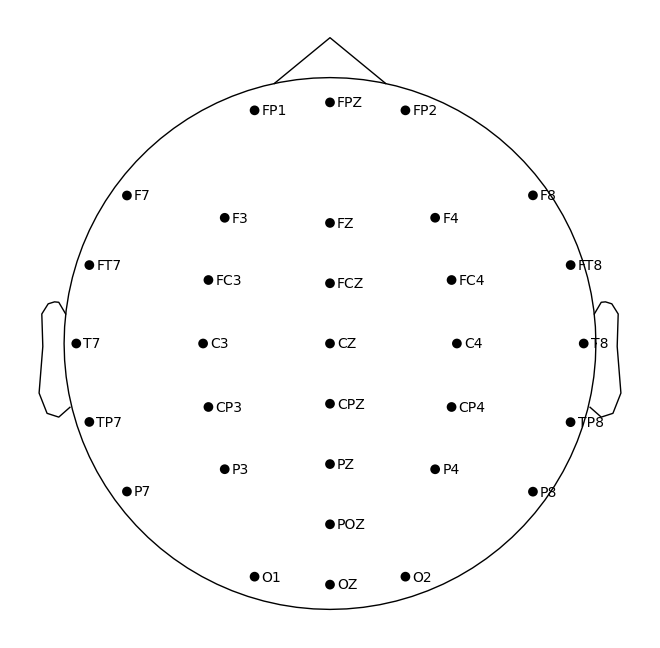

In [23]:
channels_loc = scipy.io.loadmat('chanlocs.mat')#Channel location 
positions_dict_i =  [{str(electrode[0][0]):[-electrode[5][0][0]/1000,electrode[4][0][0]/1000,electrode[6][0][0]/1000]} 
                     for electrode in channels_loc['chanlocs'][0]]#Dictionnary with x,y,z positions
positions_dict = {}
for i in positions_dict_i:
     positions_dict.update(i)
        
from mne import channels#

montage = channels.make_dig_montage(positions_dict,coord_frame='head')
positions = np.array([x[-1][:2] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
names = np.array([x[0] for x in np.array(list(montage.get_positions()['ch_pos'].items()),dtype=object)[:,:]])
montage.plot();
np.save('positions',positions)#saving the positions

Everything is now ready to be used in _hmp_

In [24]:
stacked_data = hmp.utils.stack_data(unstacked_data.data)
init = hmp.models.hmp(stacked_data, sfreq=100, event_width=50, cpus=4)

__Specifically for data already transformed to PC space:__ we cannot use the default functions as we do not have access to the raw data and we need to reconstruct the activity. This is why in this application we use very specific functions ```init.event_times``` and ```hmp.utils.reconstruct``` that aim at reconstructing channel activity based on the unmixing matrix from the fitted PCA.

Estimating 6 events model with 1 starting point(s)
Parameters estimated for 6 events model


/home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/src/hsmm_mvpy/visu.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'event' in estimated:


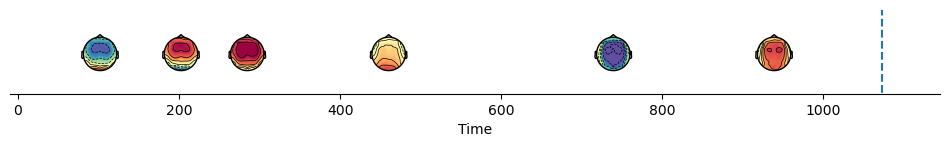

In [25]:
model = init.fit_single(6) 
mean_event_times_selected = init.event_times(model.eventprobs.dropna('event'))
electrodes_selected = xr.DataArray(hmp.utils.reconstruct(model.magnitudes.T, mat['coeff10'][:,:10], 
                            mat['latent10'][:10], np.mean(mat['data'],axis=0)))
hmp.visu.plot_topo_timecourse(electrodes_selected, mean_event_times_selected, positions, 
                               init, magnify=1, figsize=(12,1),
                                time_step = 1000/init.sfreq,  times_to_display = np.mean(ends - starts),
                                ylabels='5 events model', vmin=-10, vmax=10)